# Outline
1. Load the dataset
2. VGG16 with modification to network head
3. Using pre-trained models
4. Storing intermidiate models
5. Resnet
6. Inception v3
7. Exercises

In [7]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader



In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Dataset, Transforms, Visualization

In [9]:
transforms_train = transforms.Compose(
  [transforms.RandomResizedCrop(224),
   transforms.RandomHorizontalFlip(),
   transforms.ToTensor(),
   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
  )
transforms_test = transforms.Compose(
  [transforms.RandomResizedCrop(224),
   transforms.ToTensor(),
   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

In [10]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transforms_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transforms_test)

100%|██████████| 170498071/170498071 [00:03<00:00, 43037044.20it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [11]:
num_classes = 10
batch_size = 4

In [12]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,shuffle=True)

In [13]:
dataiter = iter(trainloader)
for images, labels in dataiter:
    print(images.shape)  # Shape of the batch of images
    print(images[1].shape)  # Shape of the first image in the batch
    print(labels[1].item())  # Label of the first image in the batch
    break  # Exit after processing the first batch


torch.Size([4, 3, 224, 224])
torch.Size([3, 224, 224])
8


In [14]:
def imshow(img, title):
    npimg = img.numpy() / 2 + 0.5
    plt.figure(figsize=(batch_size ,1))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.title(title)
    plt.show()

In [15]:
def show_batch_images(dataloader):
    images, labels = next(iter(dataloader))
    img = torchvision.utils.make_grid(images)
    imshow(img, title=[str(x.item()) for x in labels])

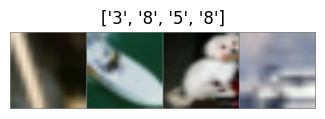

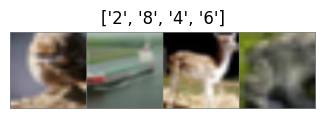

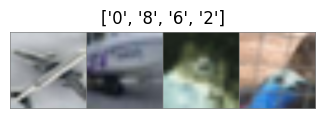

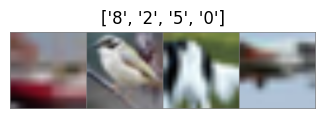

In [16]:
for i in range(4):
    show_batch_images(trainloader)

# Creating VGG16

In [17]:
from torchvision import models


In [18]:
vgg = models.vgg16_bn()

In [19]:
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [20]:
print(vgg.features[0])

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


In [21]:
print(vgg.classifier[6])


Linear(in_features=4096, out_features=1000, bias=True)


In [23]:
final_in_features = vgg.classifier[6].in_features
mod_classifier = list(vgg.classifier.children())[:-1]
mod_classifier.extend([nn.Linear(final_in_features, num_classes)])
print(mod_classifier)


[Linear(in_features=25088, out_features=4096, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False), Linear(in_features=4096, out_features=4096, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False), Linear(in_features=4096, out_features=10, bias=True)]


In [24]:
vgg.classifier = nn.Sequential(*mod_classifier)
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

# Training CIFAR10


In [25]:
batch_size = 16

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,shuffle=False)

In [26]:
def evaluation(model, test_dataloader):
  total, correct = 0, 0
  for data in test_dataloader:
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    _, pred = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (pred == labels).sum().item()
  return 100 * correct / total


In [27]:
vgg = vgg.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg.parameters(), lr=0.05)


In [29]:
loss_epoch_arr = []
max_epochs = 1
n_iters = np.ceil(50000 / batch_size)

for epoch in range(max_epochs):
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = vgg(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        if i % 100 == 0:
            print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))

    loss_epoch_arr.append(loss.item())

    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (
        epoch, max_epochs,
        evaluation(vgg, testloader),
        evaluation(vgg, trainloader))
    )

    # Move memory management outside the inner loop
    del inputs, labels, outputs
    torch.cuda.empty_cache()

plt.plot(loss_epoch_arr)
plt.show()


Iteration: 0/3125, Loss: 2.55
Iteration: 100/3125, Loss: 2.34
Iteration: 200/3125, Loss: 2.03
Iteration: 300/3125, Loss: 2.17
Iteration: 400/3125, Loss: 2.10
Iteration: 500/3125, Loss: 2.25
Iteration: 600/3125, Loss: 2.23
Iteration: 700/3125, Loss: 2.26
Iteration: 800/3125, Loss: 2.11
Iteration: 900/3125, Loss: 2.16
Iteration: 1000/3125, Loss: 2.16
Iteration: 1100/3125, Loss: 2.18
Iteration: 1200/3125, Loss: 2.52
Iteration: 1300/3125, Loss: 2.21
Iteration: 1400/3125, Loss: 2.17
Iteration: 1500/3125, Loss: 1.85
Iteration: 1600/3125, Loss: 2.00
Iteration: 1700/3125, Loss: 2.12
Iteration: 1800/3125, Loss: 2.31
Iteration: 1900/3125, Loss: 2.14
Iteration: 2000/3125, Loss: 2.22
Iteration: 2100/3125, Loss: 2.12
Iteration: 2200/3125, Loss: 2.31
Iteration: 2300/3125, Loss: 1.92
Iteration: 2400/3125, Loss: 2.40
Iteration: 2500/3125, Loss: 1.93
Iteration: 2600/3125, Loss: 3.09
Iteration: 2700/3125, Loss: 1.84
Iteration: 2800/3125, Loss: 1.98
Iteration: 2900/3125, Loss: 2.29
Iteration: 3000/3125, 

KeyboardInterrupt: 

# Freeze layers of Convolutional Operations

In [30]:
batch_size = 16

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,shuffle=False)

In [31]:
vgg = models.vgg16_bn(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 528M/528M [00:07<00:00, 76.7MB/s]


In [32]:
final_in_features = vgg.classifier[6].in_features
mod_classifier = list(vgg.classifier.children())[:-1]
mod_classifier.extend([nn.Linear(final_in_features, num_classes)])
vgg.classifier = nn.Sequential(*mod_classifier)
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [33]:
for param in vgg.parameters():
  param.requires_grad = False

In [34]:
final_in_features = vgg.classifier[6].in_features
vgg.classifier[6] = nn.Linear(final_in_features, num_classes)

In [35]:
for param in vgg.parameters():
  if param.requires_grad:
    print(param.shape)

torch.Size([10, 4096])
torch.Size([10])


In [36]:
vgg = vgg.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg.parameters(), lr=0.05)


In [37]:
loss_epoch_arr = []
max_epochs = 1
n_iters = np.ceil(50000 / batch_size)

for epoch in range(max_epochs):
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = vgg(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        if i % 100 == 0:
            print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))

    loss_epoch_arr.append(loss.item())

    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (
        epoch, max_epochs,
        evaluation(vgg, testloader),
        evaluation(vgg, trainloader))
    )

    # Move memory management outside the inner loop
    del inputs, labels, outputs
    torch.cuda.empty_cache()

plt.plot(loss_epoch_arr)
plt.show()

Iteration: 0/3125, Loss: 2.33


KeyboardInterrupt: 

# With model copies

In [38]:
import copy

In [40]:
loss_epoch_arr = []
max_epochs = 1

min_loss = 1000

n_iters = np.ceil(50000 / batch_size)

for epoch in range(max_epochs):
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = vgg(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        if min_loss > loss.item():
            min_loss = loss.item()
            best_model = copy.deepcopy(vgg.state_dict())
            print('Min loss %0.2f' % min_loss)


        if i % 100 == 0:
            print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))



    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (
        epoch, max_epochs,
        evaluation(vgg, testloader),
        evaluation(vgg, trainloader))
    )

    # Move memory management outside the inner loop
    del inputs, labels, outputs
    torch.cuda.empty_cache()
loss_epoch_arr.append(loss.item())


Min loss 2.28
Iteration: 0/3125, Loss: 2.28
Min loss 2.13
Min loss 2.09
Min loss 1.91
Min loss 1.83
Min loss 1.57
Min loss 1.08
Iteration: 100/3125, Loss: 1.27
Min loss 0.93
Iteration: 200/3125, Loss: 2.15


KeyboardInterrupt: 

In [41]:
vgg.load_state_dict(best_model)
print(evaluation(vgg, testloader), evaluation(vgg, trainloader))


KeyboardInterrupt: 

# ResNet Model

In [42]:
resnet = models.resnet18(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 148MB/s]


In [43]:
print(resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [44]:
for param in resnet.parameters():
  param.requires_grad = False

In [ ]:
in_features = resnet.fc.in_features
resnet.fc = nn.Linear(in_features, num_classes)
print(resnet)

In [46]:
for param in resnet.parameters():
  if param.requires_grad:
    print(param.shape)

torch.Size([10, 512])
torch.Size([10])


In [47]:
resnet = resnet.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet.parameters(), lr=0.01)

In [ ]:
loss_epoch_arr = []
max_epochs = 4
n_iters = np.ceil(50000 / batch_size)
min_loss = 1000

for epoch in range(max_epochs):
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = resnet(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        if min_loss > loss.item():
            min_loss = loss.item()
            best_model = copy.deepcopy(resnet.state_dict())
            print('Min loss %0.2f' % min_loss)


        if i % 100 == 0:
            print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))



    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (
        epoch, max_epochs,
        evaluation(resnet, testloader),
        evaluation(resnet, trainloader))
    )

    # Move memory management outside the inner loop
    del inputs, labels, outputs
    torch.cuda.empty_cache()


plt.plot(loss_epoch_arr)
plt.show()


In [ ]:
resnet.load_state_dict(best_model)
print(evaluation(resnet, testloader), evaluation(resnet, trainloader))

# Inception model

In [48]:
inception = models.inception_v3(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 160MB/s] 


In [ ]:
print(inception)

In [50]:
for param in inception.parameters():
  param.requires_grad = False

In [ ]:
aux_in_features = inception.AuxLogits.fc.in_features
inception.AuxLogits.fc = nn.Linear(aux_in_features, num_classes)

in_features = inception.fc.in_features
inception.fc = nn.Linear(in_features, num_classes)
print(inception)

In [52]:
for param in inception.parameters():
  if param.requires_grad:
    print(param.shape)

torch.Size([10, 768])
torch.Size([10])
torch.Size([10, 2048])
torch.Size([10])


In [53]:
transforms_train2 = transforms.Compose([
  transforms.RandomResizedCrop(299),
  transforms.RandomHorizontalFlip(),
  transforms.ToTensor(),
  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transforms_test2 = transforms.Compose([
  transforms.Resize(299),
  transforms.CenterCrop(299),
  transforms.ToTensor(),
  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [54]:
trainset2 = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transforms_train2)
testset2 = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transforms_test2)

batch_size = 16

trainloader2 = torch.utils.data.DataLoader(trainset2, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader2 = torch.utils.data.DataLoader(testset2, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [55]:
inception = inception.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(inception.parameters(), lr=0.01)

In [57]:
def evaluation_inception(model, testdataloader):
  total, correct = 0, 0

  for data in testdataloader:
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    outputs, aux2_outputs = model(inputs)
    _, pred = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (pred == labels).sum().item()

  return 100 * correct / total

In [ ]:
loss_epoch_arr = []
max_epochs =
n_iters = np.ceil(50000 / batch_size)
min_loss = 1000

for epoch in range(max_epochs):
    for i, data in enumerate(trainloader2, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs, aux_outputs = inception(inputs)
        loss = loss_fn(outputs, labels+ 0.3 *loss_fn(aux_outputs, labels))
        loss.backward()
        optimizer.step()

        if min_loss > loss.item():
            min_loss = loss.item()
            best_model = copy.deepcopy(inception.state_dict())
            print('Min loss %0.2f' % min_loss)


        if i % 100 == 0:
            print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))



    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (

))

    # Move memory management outside the inner loop
    del inputs, labels, outputs
    torch.cuda.empty_cache()


plt.plot(loss_epoch_arr)
plt.show()

In [ ]:
inception.load_state_dict(best_model)
print(evaluation_inception(inception, testloader2), evaluation_inception(inception, trainloader2))


# Exercises

1. Structure of the above code into a series of functions and then call them.
2. Try out different hyperparameter combinations and try to achieve the published results on different networks.
3. Try out the CIFAR-100 and STL-10 datasets and see if you can achieve better results.
4. Try out the another model - SqueezeNet.
5. Try training multiple layers and not just the last one.